In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip -q install -U ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 609.5/609.5 kB 7.7 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/torch/hub.py:286: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
requirements: Ultralytics requirement ['gitpython>=3.1.30'] not found, attempting AutoUpdate...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.7 MB/s eta 

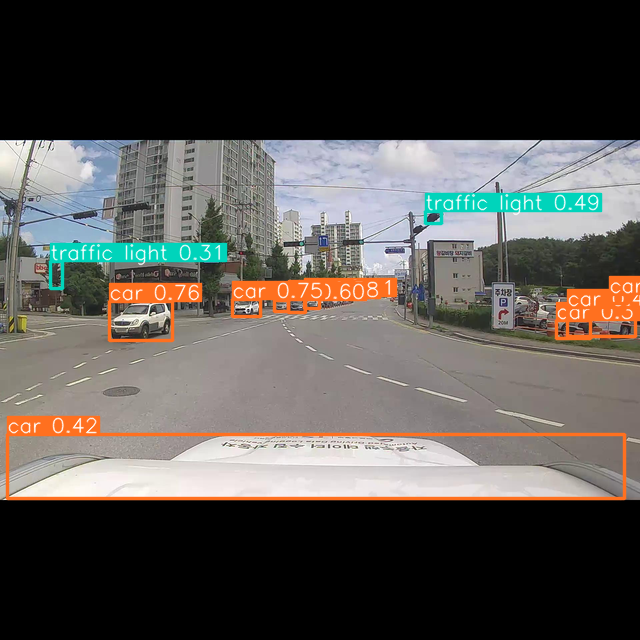

In [3]:
import torch
from PIL import Image
import matplotlib

def add_padding(img, target_width, target_height):
    width, height = img.size
    new_img = Image.new("RGB", (target_width, target_height), color="black")
    new_img.paste(img, ((target_width - width) // 2, (target_height - height) // 2))
    return new_img

# 이미지 패딩 추가 및 리사이즈
img_path = '/content/drive/MyDrive/data/2DB/training/images/AGS_DA_00C_BA_22090202_000471.jpg'
original_image = Image.open(img_path)
padded_image = add_padding(original_image, 1920, 1920)
resized_image = padded_image.resize((640, 640), Image.LANCZOS)

# Model
model_ex1 = torch.hub.load('ultralytics/yolov5', 'yolov5l6', pretrained=True)

# 이미지를 모델에 통과
results = model_ex1(resized_image)
# Results
results.print()

# Bounding box를 포함한 이미지를 화면에 바로 표시
results.show()

In [4]:
import os
import json
import torch
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image, ImageOps
from tqdm import tqdm
import numpy as np

from torchvision.transforms import functional as F
from PIL import ImageDraw

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class CustomDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.image_dir = os.path.join(root_dir, "images")
        self.label_dir = os.path.join(root_dir, "labels")

        self.image_files = sorted([f for f in tqdm(os.listdir(self.image_dir), desc="Loading Images") if f.endswith('.jpg')])

        self.label_map = {
            "none": 0,
            "car": 1,
            "truck": 2,
            "bus": 3,
            "special_vehicle": 4,
            "motorcycle": 5,
            "bicycle": 6,
            "pedestrian": 7,
            "traffic_sign": 8,
            "traffic_light": 9
        }
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        self.labels = []
        for idx in range(len(self.image_files)):
            img_path = os.path.join(self.image_dir, self.image_files[idx])
            label_path = os.path.join(self.label_dir, os.path.splitext(self.image_files[idx])[0] + ".json")

            with open(label_path, 'r', encoding='utf-8') as file:
                label_data = json.load(file)

            boxes = [anno['Coordinate'] for anno in label_data['Annotation']]
            labels = [anno['Label'] for anno in label_data['Annotation']]

            targets = []
            for box, label in zip(boxes, labels):
                target = [self.label_map[label]] + box
                targets.append(target)

            self.labels.append(targets)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
      if torch.is_tensor(idx):
          idx = idx.tolist()

      img_path = os.path.join(self.image_dir, self.image_files[idx])
      label_path = img_path.replace("images", "labels").replace(".jpg", ".json")

      orig_img = Image.open(img_path)
      orig_width, orig_height = orig_img.size

      # Determine new size maintaining aspect ratio
      if orig_width > orig_height:
          new_width = 640
          new_height = int(orig_height * (640 / orig_width))
      else:
          new_height = 640
          new_width = int(orig_width * (640 / orig_height))

      # Calculate the gain and padding
      gain_w = new_width / orig_width
      gain_h = new_height / orig_height
      pad_w = (640 - new_width) / 2
      pad_h = (640 - new_height) / 2

      # Resize the image while maintaining aspect ratio
      img = orig_img.resize((new_width, new_height))

      # Pad to square 640x640
      img = ImageOps.expand(img, border=(int(pad_w), int(pad_h), int(pad_w), int(pad_h)), fill='black')
      img = self.transform(img)

      with open(label_path, 'r', encoding='utf-8') as file:
          label_data = json.load(file)

      boxes = [anno['Coordinate'] for anno in label_data['Annotation']]
      labels = [anno['Label'] for anno in label_data['Annotation']]

      # Adjust bounding boxes after resize and pad
      boxes = [[(box[0] + box[2] / 2) * gain_w + pad_w,
                (box[1] + box[3] / 2) * gain_h + pad_h,
                box[2] * gain_w,
                box[3] * gain_h] for box in boxes]

      # Convert string labels to integer labels
      labels = [int(self.label_map[label]) for label in labels]

      # Convert boxes and labels to targets format for YOLOv5 compatibility
      targets = []
      for box, label in zip(boxes, labels):
          # Normalize the coordinates
          target = [label] + [coord/640 for coord in box]
          targets.append(target)

      targets = torch.tensor(targets, dtype=torch.float32)

      original_shape = (orig_height, orig_width)
      shapes = (original_shape, ((gain_h, gain_w), (pad_h, pad_w)))

      return img, targets, img_path, shapes

    def revert_transforms(self, boxes, orig_width, orig_height):
        """원래 이미지 크기로 바운딩 박스 좌표 변환"""
        width_ratio = orig_width / 640
        height_ratio = orig_height / 640
        boxes = [[box[0] * width_ratio, box[1] * height_ratio,
          box[2] * width_ratio, box[3] * height_ratio] for box in boxes]

        return boxes


Loading Images: 100%|██████████| 100/100 [00:00<00:00, 498728.18it/s]


Shape in training loop: (1080, 1920)

Image tensor: torch.Size([3, 640, 640])
Targets: torch.Size([9, 5])


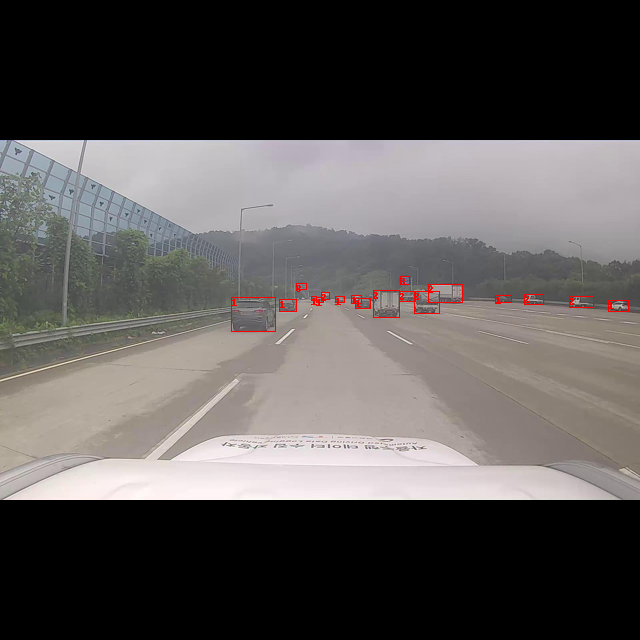

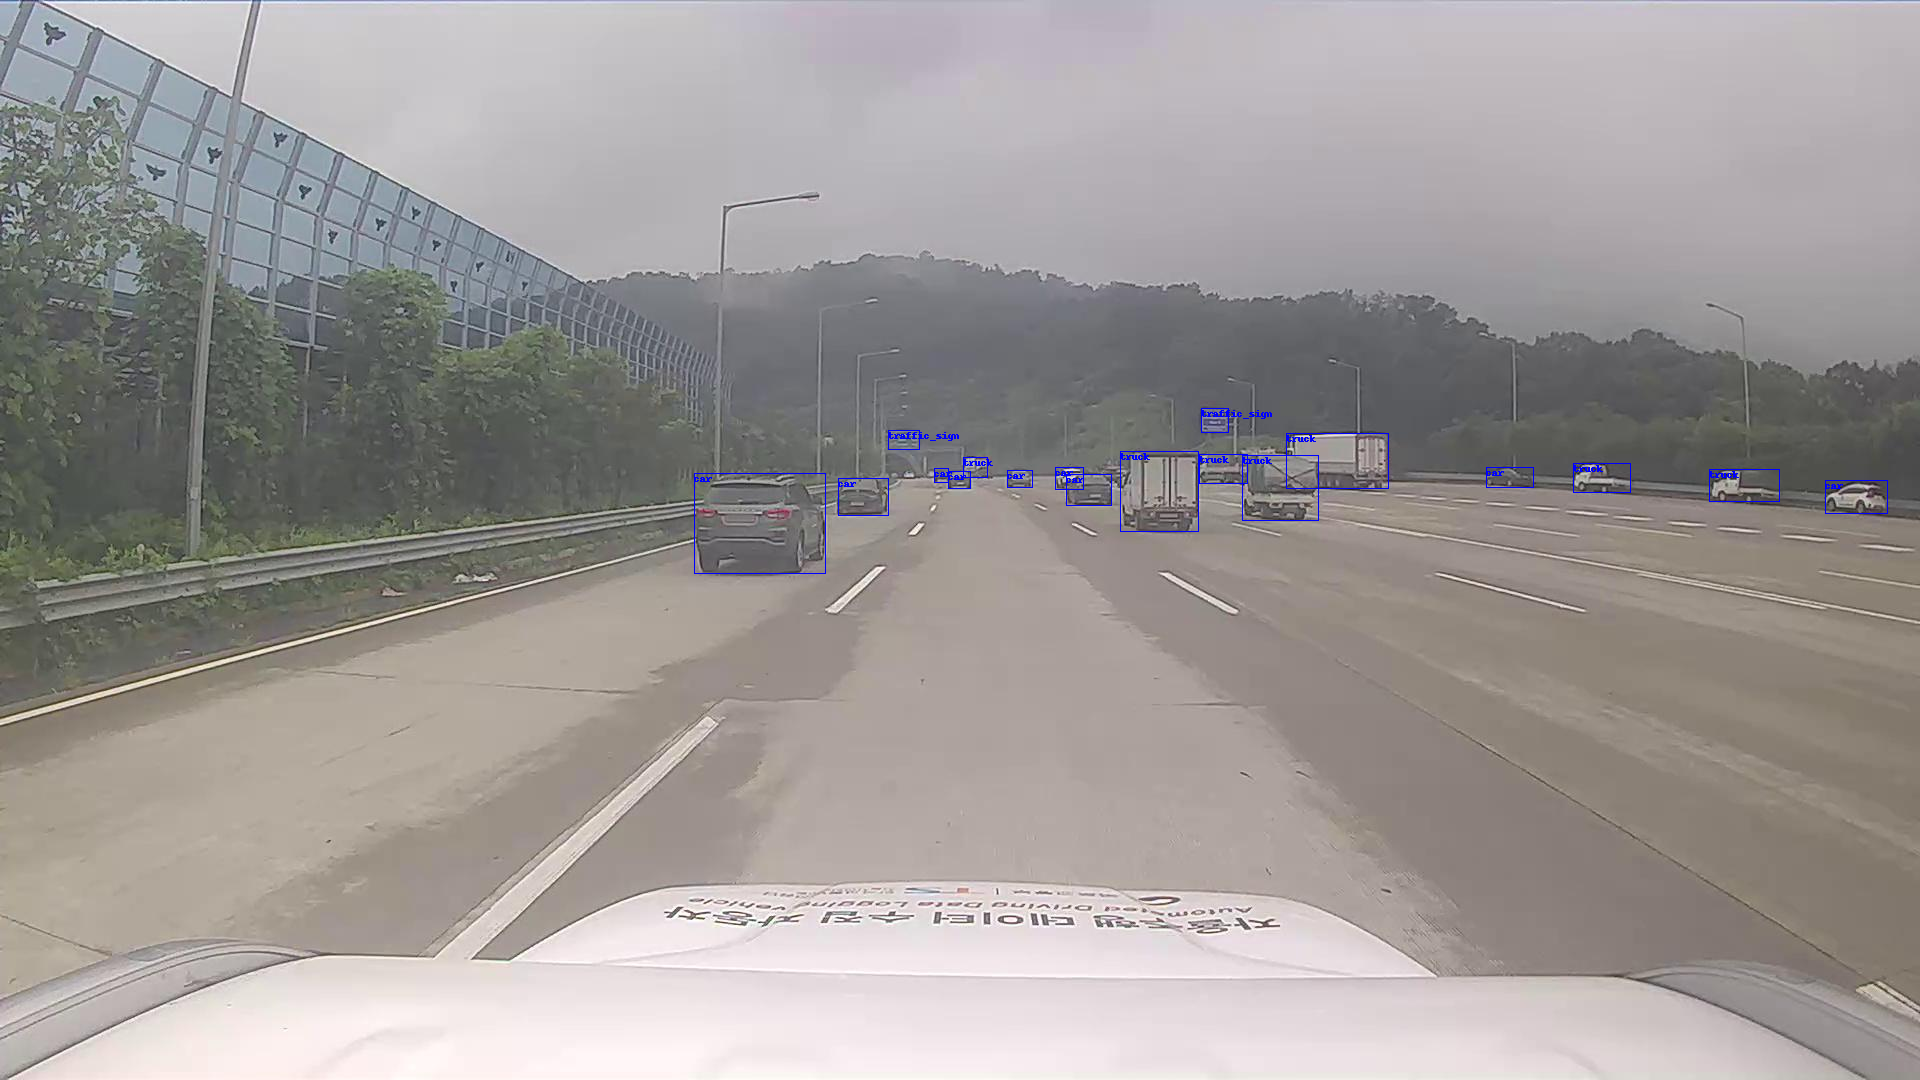

((1080, 1920), ((0.3333333333333333, 0.3333333333333333), (140.0, 0.0)))
Image path: /content/drive/MyDrive/data/2DB2/test/images/AGS_DA_00C_PR_22090201_001447.jpg
Shapes: ((1080, 1920), ((0.3333333333333333, 0.3333333333333333), (140.0, 0.0)))


In [5]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    im, label, path, shapes = zip(*batch)  # transposed
    new_labels = []
    for i, lb in enumerate(label):
        img_idx_tensor = torch.full((lb.shape[0], 1), i, dtype=torch.float32)  # create a tensor filled with the image index
        new_labels.append(torch.cat((img_idx_tensor, lb), 1))  # prepend the image index to each target
    return torch.stack(im, 0), torch.cat(new_labels, 0), path, shapes

from IPython.display import display

def visualize_original_boxes(dataset, idx):
    img, _, img_path, _ = dataset[idx]
    orig_img = Image.open(img_path)  # Load original image without any transformations
    draw = ImageDraw.Draw(orig_img)

    label_path = img_path.replace("images", "labels").replace(".jpg", ".json")
    with open(label_path, 'r', encoding='utf-8') as file:
        label_data = json.load(file)

    boxes = [anno['Coordinate'] for anno in label_data['Annotation']]
    labels = [anno['Label'] for anno in label_data['Annotation']]

    # Convert boxes from [x_min, y_min, width, height] to [x_cen, y_cen, width, height]
    boxes = [[box[0] + box[2] / 2, box[1] + box[3] / 2, box[2], box[3]] for box in boxes]

    for box, label in zip(boxes, labels):
        draw.rectangle([box[0] - box[2] / 2, box[1] - box[3] / 2, box[0] + box[2] / 2, box[1] + box[3] / 2], outline="blue")
        draw.text((box[0] - box[2] / 2, box[1] - box[3] / 2), label, fill="blue")

    display(orig_img)


def visualize_sample(dataset, idx):
    img, targets, _, _ = dataset[idx]
    img = F.to_pil_image(img.cpu() * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) +
                         torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1))
    draw = ImageDraw.Draw(img)

    for target in targets:
        label, x_cen, y_cen, w, h = target
        # Convert normalized coordinates to pixel coordinates
        x, y, w, h = x_cen*640, y_cen*640, w*640, h*640
        draw.rectangle([x - w / 2, y - h / 2, x + w / 2, y + h / 2], outline="red")
        draw.text((x - w / 2, y - h / 2), str(int(label)), fill="red")

    display(img)

# load dataset with loader
train_dataset = CustomDataset(root_dir="/content/drive/MyDrive/data/2DB2/training")
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4, collate_fn=collate_fn)

val_dataset = CustomDataset(root_dir="/content/drive/MyDrive/data/2DB2/validation")
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4, collate_fn=collate_fn)

test_dataset = CustomDataset(root_dir="/content/drive/MyDrive/data/2DB2/test")
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=4, collate_fn=collate_fn)

# shape
img55, targets, img_path, shapes = test_dataset[3]  # get the 3th item
print("Shape in training loop:", shapes[0])  # print first item for brevity
print("\nImage tensor:", img55.shape)
print("Targets:", targets.shape)
visualize_sample(test_dataset, 0)
visualize_original_boxes(test_dataset, 0)
print(shapes[:5])
print("Image path:", img_path)
print("Shapes:", shapes)

In [6]:
!git clone https://github.com/ultralytics/yolov5.git
import sys
sys.path.append('/content/YOLOv5/')
import locale
locale.getpreferredencoding = lambda: "UTF-8"
print(torch.cuda.is_available())

Cloning into 'yolov5'...
remote: Enumerating objects: 15926, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 15926 (delta 20), reused 23 (delta 8), pack-reused 15880
Receiving objects: 100% (15926/15926), 14.66 MiB | 24.13 MiB/s, done.
Resolving deltas: 100% (10915/10915), done.
True


In [7]:
import yaml
import torch
from models.yolo import DetectionModel, Detect
from utils.general import intersect_dicts
import torch.nn as nn

# YOLOv5 모델에서 Detect 레이어의 출력 채널 수를 확인하여 클래스 수를 확인합니다.
def get_num_classes_from_detect_layer(model):
    for module in model.modules():
        if isinstance(module, nn.Conv2d) and module.kernel_size == (1, 1):
            # (num_anchors * (5 + num_classes)) = out_channels
            # YOLO에서는 각 bounding box당 5개의 값 (x, y, w, h, confidence) 및 클래스별 확률을 가집니다.
            out_channels = module.out_channels
            if out_channels % 3 == 0:  # 3개의 앵커를 감안
                return (out_channels // 3) - 5
    return -1

# Create a new YOLO model with 10 classes
model = DetectionModel(cfg='/content/drive/MyDrive/models/setto10.yaml', nc=10)
print('Before update:', get_num_classes_from_detect_layer(model))

# Load pretrained weights
pretrained_weights = torch.load('yolov5l6.pt')
model_dict = model.state_dict()
# Update the model's weights with the pretrained weights, but skip mismatched layers
pretrained_dict = {k: v for k, v in pretrained_weights.items() if k in model_dict and model_dict[k].shape == v.shape}
model_dict.update(pretrained_dict)
model.load_state_dict(model_dict)
model.info()
print('After update:', get_num_classes_from_detect_layer(model))
# Get the indices of the convolutional layers right before the Detect layer
conv_indices = [i-1 for i in [17, 20, 23]]

# Add the 'hyp' attribute if it doesn't exist
if not hasattr(model, 'hyp'):
    model.hyp = {
        "lr0": 0.01,
        "lrf": 0.1,
        "momentum": 0.937,
        "weight_decay": 0.0005,
        "warmup_epochs": 3.0,
        "warmup_momentum": 0.8,
        "warmup_bias_lr": 0.1,
        "box": 0.05,
        "cls": 0.3,
        "cls_pw": 1.0,
        "obj": 0.7,
        "obj_pw": 1.0,
        "iou_t": 0.20,
        "anchor_t": 4.0,
        "fl_gamma": 0.0,
        "hsv_h": 0,
        "hsv_s": 0,
        "hsv_v": 0,
        "degrees": 0.0,
        "translate": 0,
        "scale": 0,
        "shear": 0,
        "perspective": 0.0,
        "flipud": 0.0,
        "fliplr": 0.0,
        "mosaic": 0.0,
        "mixup": 0.0,
        "copy_paste": 0.0
    }
label_map = {
    0: "none",
    1: "car",
    2: "truck",
    3: "bus",
    4: "special_vehicle",
    5: "motorcycle",
    6: "bicycle",
    7: "pedestrian",
    8: "traffic_sign",
    9: "traffic_light"
}
model.names = label_map


                 from  n    params  module                                  arguments                     
  0                -1  1      7040  models.common.Conv                      [3, 64, 6, 2, 2]              
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  3    156928  models.common.C3                        [128, 128, 3]                 
  3                -1  1    295424  models.common.Conv                      [128, 256, 3, 2]              
  4                -1  6   1118208  models.common.C3                        [256, 256, 6]                 
  5                -1  1   1180672  models.common.Conv                      [256, 512, 3, 2]              
  6                -1  9   6433792  models.common.C3                        [512, 512, 9]                 
  7                -1  1   4720640  models.common.Conv                      [512, 1024, 3, 2]             
  8                -1  3   9971712  

Before update: 10


setto10 summary: 368 layers, 46186759 parameters, 46186759 gradients


After update: 10


In [8]:
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from utils.metrics import ConfusionMatrix, ap_per_class, box_iou
from utils.plots import output_to_target, plot_images, plot_val_study

from utils.general import (LOGGER, TQDM_BAR_FORMAT, Profile, check_dataset, check_img_size, check_requirements,
                           check_yaml, coco80_to_coco91_class, colorstr, increment_path, non_max_suppression,
                           print_args, scale_boxes, xywh2xyxy, xyxy2xywh)
from pathlib import Path
def print_results(dataset_name, results):
    mp, mr, map50, map, *losses = results
    print(f"\n{dataset_name} Results")
    print("-" * 50)
    print(f"Precision: {mp:.4f}")
    print(f"Recall: {mr:.4f}")
    print(f"mAP@0.5: {map50:.4f}")
    print(f"mAP@0.5:0.95: {map:.4f}")
    print(f"Box Loss: {losses[0]:.4f}")
    print(f"Obj Loss: {losses[1]:.4f}")
    print(f"Class Loss: {losses[2]:.4f}")
    print("-" * 50)

def process_batch(detections, labels, iouv):
    """
    Return correct prediction matrix
    Arguments:
        detections (array[N, 6]), x1, y1, x2, y2, conf, class
        labels (array[M, 5]), class, x1, y1, x2, y2
    Returns:
        correct (array[N, 10]), for 10 IoU levels
    """
    correct = np.zeros((detections.shape[0], iouv.shape[0])).astype(bool)
    iou = box_iou(labels[:, 1:], detections[:, :4])
    correct_class = labels[:, 0:1] == detections[:, 5]
    for i in range(len(iouv)):
        x = torch.where((iou >= iouv[i]) & correct_class)  # IoU > threshold and classes match
        if x[0].shape[0]:
            matches = torch.cat((torch.stack(x, 1), iou[x[0], x[1]][:, None]), 1).cpu().numpy()  # [label, detect, iou]
            if x[0].shape[0] > 1:
                matches = matches[matches[:, 2].argsort()[::-1]]
                matches = matches[np.unique(matches[:, 1], return_index=True)[1]]
                # matches = matches[matches[:, 2].argsort()[::-1]]
                matches = matches[np.unique(matches[:, 0], return_index=True)[1]]
            correct[matches[:, 1].astype(int), i] = True
    return torch.tensor(correct, dtype=torch.bool, device=iouv.device)

def run(
        model,
        batch_size=8,
        imgsz=640,
        conf_thres=0.001,
        iou_thres=0.6,
        max_det=50,
        augment=False,
        dataloader=None,
        compute_loss=None,
        plots=True
):
    # Initialize/load model and set device
    training = model is not None
    if training:  # called by train.py
        device = next(model.parameters()).device

    # Configure
    nc = 10
    iouv = torch.linspace(0.5, 0.95, 10, device=device)  # iou vector for mAP@0.5:0.95
    niou = iouv.numel()

    seen = 0
    loss = torch.zeros(3, device=device)
    s = ('%22s' + '%11s' * 6) % ('Class', 'Images', 'Instances', 'P', 'R', 'mAP50', 'mAP50-95')
    tp, fp, p, r, f1, mp, mr, map50, ap50, map = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
    jdict, stats, ap, ap_class = [], [], [], []
    confusion_matrix = ConfusionMatrix(nc=nc)

    for batch_i, (im, targets, paths, shapes) in enumerate(dataloader):
        im = im.to(device)
        targets = targets.to(device)
        with torch.no_grad():
           preds, train_out = model(im) if compute_loss else (model(im, augment=augment), None)
        if compute_loss:
            loss += compute_loss(train_out, targets)[1]
        names = model.names if hasattr(model, 'names') else model.module.names
        nb, _, height, width = im.shape  # batch size, channels, height, width


        # NMS
        targets[:, 2:] *= torch.tensor((width, height, width, height), device=device)  # to pixels

        preds = non_max_suppression(preds,
                                    conf_thres,
                                    iou_thres,
                                    multi_label=False,
                                    agnostic=False,
                                    max_det=max_det)
        # Metrics
        for si, pred in enumerate(preds):
            labels = targets[targets[:, 0] == si, 1:]
            nl, npr = labels.shape[0], pred.shape[0]  # number of labels, predictions
            path, shape = Path(paths[si]), shapes[si][0]
            correct = torch.zeros(npr, niou, dtype=torch.bool, device=device)  # init
            seen += 1

            if npr == 0:
                if nl:
                    stats.append((correct, *torch.zeros((2, 0), device=device), labels[:, 0]))
                    if plots:
                        confusion_matrix.process_batch(detections=None, labels=labels[:, 0])
                continue

            predn = pred.clone()
            scale_boxes(im[si].shape[1:], predn[:, :4], shape, shapes[si][1])  # native-space pred
            # Evaluate
            if nl:
                tbox = xywh2xyxy(labels[:, 1:5])  # target boxes
                scale_boxes(im[si].shape[1:], tbox, shape, shapes[si][1])  # native-space labels
                labelsn = torch.cat((labels[:, 0:1], tbox), 1)  # native-space labels
                correct = process_batch(predn, labelsn, iouv)
                if plots:
                    confusion_matrix.process_batch(predn, labelsn)
            stats.append((correct, pred[:, 4], pred[:, 5], labels[:, 0]))  # (correct, conf, pcls, tcls)


    # Compute metrics
    stats = [torch.cat(x, 0).cpu().numpy() for x in zip(*stats)]
    if len(stats) and stats[0].any():
        tp, fp, p, r, f1, ap, ap_class = ap_per_class(*stats, names=names)
        ap50, ap = ap[:, 0], ap.mean(1)
        mp, mr, map50, map = p.mean(), r.mean(), ap50.mean(), ap.mean()
    else:
        mp, mr, map50, map = 0.0, 0.0, 0.0, 0.0

    maps = np.zeros(nc) + map
    for i, c in enumerate(ap_class):
        maps[c] = ap[i]

    return (mp, mr, map50, map, *(loss.cpu() / len(dataloader)).tolist()), maps


In [9]:
from tqdm import tqdm
from utils.loss import ComputeLoss

model = model.to(device)
compute_loss = ComputeLoss(model)  # initialize the ComputeLoss class
def train_one_epoch(model, parameters, loader, optimizer, num_epochs, epoch):
    model.train()
    running_loss = 0.0
    # Using tqdm to show progress bar
    for i, data in tqdm(enumerate(loader), total=len(loader), desc=f"Epoch {epoch+1}/{num_epochs}"):

        inputs, labels, _, _ = data

        inputs = inputs.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        # Compute YOLO loss
        loss, _ = compute_loss(outputs, labels.to(device))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(parameters, max_norm=1)
        optimizer.step()
        running_loss += loss.item()

        if i % 50 == 49:
            last_loss = running_loss / 100
            print(f'\n  batch {i + 1} loss: {last_loss}')
            running_loss = 0.0

    return last_loss

In [10]:
# Transfer Learning: Training the head only...
print("Transfer Learning: Training the head only...")
# Freeze specific layers for Transfer Learning
# 모든 gradients 비활성화
for param in model.parameters():
    param.requires_grad = False

# 마지막 검출 계층의 gradients 활성화
for param in model.model[-1].parameters():
    param.requires_grad = True

num_epochs_transfer = 10
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()))
scheduler = ReduceLROnPlateau(optimizer, factor=0.01)

for epoch in range(num_epochs_transfer):
    train_one_epoch(model, model.model[-1].parameters(), train_loader, optimizer, num_epochs_transfer, epoch)
    model.eval()
    results, _ = run(model=model, dataloader=val_loader, compute_loss=compute_loss)
    print_results("validation", results)

# Define the Adam optimizer and learning rate scheduler
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, factor=0.01)  # Decays learning rate by 0.1 every 10 epochs
# Fine-tuning: Training the entire model...
print("\nFine-tuning: Training the entire model...")
for param in model.parameters():
    param.requires_grad = True

num_epochs_fine_tuning = 10
for epoch in range(num_epochs_fine_tuning):
    train_one_epoch(model, model.parameters(), train_loader, optimizer, num_epochs_fine_tuning, epoch)
    model.eval()
    results, _ = run(model=model, dataloader=val_loader, compute_loss=compute_loss)
    print_results("validation", results)

Transfer Learning: Training the head only...


Epoch 1/10:  51%|█████     | 51/100 [00:37<00:28,  1.73it/s]


  batch 50 loss: 1.6665207743644714


Epoch 1/10: 100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


  batch 100 loss: 1.5418072986602782



validation Results
--------------------------------------------------
Precision: 0.0000
Recall: 0.0001
mAP@0.5: 0.0000
mAP@0.5:0.95: 0.0000
Box Loss: 0.1053
Obj Loss: 0.0463
Class Loss: 0.2395
--------------------------------------------------


Epoch 2/10:  51%|█████     | 51/100 [00:06<00:05,  8.24it/s]


  batch 50 loss: 1.4969059920310974


Epoch 2/10: 100%|██████████| 100/100 [00:12<00:00,  8.16it/s]


  batch 100 loss: 1.4570138955116272



validation Results
--------------------------------------------------
Precision: 0.0004
Recall: 0.0029
mAP@0.5: 0.0002
mAP@0.5:0.95: 0.0001
Box Loss: 0.1064
Obj Loss: 0.0446
Class Loss: 0.2127
--------------------------------------------------


Epoch 3/10:  51%|█████     | 51/100 [00:06<00:05,  8.57it/s]


  batch 50 loss: 1.4340985417366028


Epoch 3/10: 100%|██████████| 100/100 [00:12<00:00,  8.29it/s]


  batch 100 loss: 1.4693257474899293



validation Results
--------------------------------------------------
Precision: 0.0005
Recall: 0.0036
mAP@0.5: 0.0003
mAP@0.5:0.95: 0.0001
Box Loss: 0.1080
Obj Loss: 0.0434
Class Loss: 0.2147
--------------------------------------------------


Epoch 4/10:  51%|█████     | 51/100 [00:06<00:05,  8.43it/s]


  batch 50 loss: 1.4288843250274659


Epoch 4/10: 100%|██████████| 100/100 [00:12<00:00,  8.19it/s]


  batch 100 loss: 1.454388644695282



validation Results
--------------------------------------------------
Precision: 0.0005
Recall: 0.0036
mAP@0.5: 0.0003
mAP@0.5:0.95: 0.0001
Box Loss: 0.1071
Obj Loss: 0.0438
Class Loss: 0.2088
--------------------------------------------------


Epoch 5/10:  51%|█████     | 51/100 [00:06<00:05,  8.60it/s]


  batch 50 loss: 1.4354535818099976


Epoch 5/10: 100%|██████████| 100/100 [00:12<00:00,  8.04it/s]


  batch 100 loss: 1.4277458739280702



validation Results
--------------------------------------------------
Precision: 0.0008
Recall: 0.0017
mAP@0.5: 0.0004
mAP@0.5:0.95: 0.0001
Box Loss: 0.1079
Obj Loss: 0.0436
Class Loss: 0.2077
--------------------------------------------------


Epoch 6/10:  51%|█████     | 51/100 [00:06<00:05,  8.77it/s]


  batch 50 loss: 1.4438685083389282


Epoch 6/10: 100%|██████████| 100/100 [00:12<00:00,  8.18it/s]


  batch 100 loss: 1.4152838802337646



validation Results
--------------------------------------------------
Precision: 0.0005
Recall: 0.0033
mAP@0.5: 0.0003
mAP@0.5:0.95: 0.0001
Box Loss: 0.1071
Obj Loss: 0.0438
Class Loss: 0.2086
--------------------------------------------------


Epoch 7/10:  51%|█████     | 51/100 [00:06<00:05,  8.67it/s]


  batch 50 loss: 1.4143605971336364


Epoch 7/10: 100%|██████████| 100/100 [00:12<00:00,  8.24it/s]


  batch 100 loss: 1.4277256917953491



validation Results
--------------------------------------------------
Precision: 0.0008
Recall: 0.0013
mAP@0.5: 0.0003
mAP@0.5:0.95: 0.0001
Box Loss: 0.1075
Obj Loss: 0.0441
Class Loss: 0.2096
--------------------------------------------------


Epoch 8/10:  51%|█████     | 51/100 [00:06<00:05,  8.77it/s]


  batch 50 loss: 1.4198720622062684


Epoch 8/10: 100%|██████████| 100/100 [00:11<00:00,  8.35it/s]


  batch 100 loss: 1.404281837940216



validation Results
--------------------------------------------------
Precision: 0.0004
Recall: 0.0032
mAP@0.5: 0.0003
mAP@0.5:0.95: 0.0001
Box Loss: 0.1071
Obj Loss: 0.0438
Class Loss: 0.2104
--------------------------------------------------


Epoch 9/10:  51%|█████     | 51/100 [00:06<00:05,  8.52it/s]


  batch 50 loss: 1.4017918157577514


Epoch 9/10: 100%|██████████| 100/100 [00:12<00:00,  8.24it/s]


  batch 100 loss: 1.4413077187538148



validation Results
--------------------------------------------------
Precision: 0.0004
Recall: 0.0032
mAP@0.5: 0.0003
mAP@0.5:0.95: 0.0001
Box Loss: 0.1069
Obj Loss: 0.0447
Class Loss: 0.2086
--------------------------------------------------


Epoch 10/10:  51%|█████     | 51/100 [00:06<00:05,  8.71it/s]


  batch 50 loss: 1.3991358399391174


Epoch 10/10: 100%|██████████| 100/100 [00:12<00:00,  8.27it/s]


  batch 100 loss: 1.4228339767456055



validation Results
--------------------------------------------------
Precision: 0.0006
Recall: 0.0039
mAP@0.5: 0.0003
mAP@0.5:0.95: 0.0001
Box Loss: 0.1070
Obj Loss: 0.0439
Class Loss: 0.2057
--------------------------------------------------

Fine-tuning: Training the entire model...


Epoch 1/10:  50%|█████     | 50/100 [00:13<00:12,  3.86it/s]


  batch 50 loss: 1.4256780338287354


Epoch 1/10: 100%|██████████| 100/100 [00:26<00:00,  3.73it/s]


  batch 100 loss: 1.374405527114868



validation Results
--------------------------------------------------
Precision: 0.0000
Recall: 0.0000
mAP@0.5: 0.0000
mAP@0.5:0.95: 0.0000
Box Loss: 0.1571
Obj Loss: 0.0535
Class Loss: 30.1705
--------------------------------------------------


Epoch 2/10:  50%|█████     | 50/100 [00:13<00:13,  3.82it/s]


  batch 50 loss: 1.313316731452942


Epoch 2/10: 100%|██████████| 100/100 [00:26<00:00,  3.73it/s]


  batch 100 loss: 1.3172786831855774



validation Results
--------------------------------------------------
Precision: 0.0016
Recall: 0.0114
mAP@0.5: 0.0011
mAP@0.5:0.95: 0.0004
Box Loss: 0.1023
Obj Loss: 0.0437
Class Loss: 0.1932
--------------------------------------------------


Epoch 3/10:  50%|█████     | 50/100 [00:13<00:13,  3.83it/s]


  batch 50 loss: 1.2349700617790222


Epoch 3/10: 100%|██████████| 100/100 [00:26<00:00,  3.72it/s]


  batch 100 loss: 1.2747760093212128



validation Results
--------------------------------------------------
Precision: 0.0027
Recall: 0.0113
mAP@0.5: 0.0023
mAP@0.5:0.95: 0.0006
Box Loss: 0.1021
Obj Loss: 0.0418
Class Loss: 0.1853
--------------------------------------------------


Epoch 4/10:  50%|█████     | 50/100 [00:13<00:13,  3.82it/s]


  batch 50 loss: 1.2467715191841124


Epoch 4/10: 100%|██████████| 100/100 [00:26<00:00,  3.72it/s]


  batch 100 loss: 1.2259656476974488



validation Results
--------------------------------------------------
Precision: 0.1034
Recall: 0.0113
mAP@0.5: 0.0016
mAP@0.5:0.95: 0.0005
Box Loss: 0.1005
Obj Loss: 0.0408
Class Loss: 0.1781
--------------------------------------------------


Epoch 5/10:  50%|█████     | 50/100 [00:13<00:12,  3.86it/s]


  batch 50 loss: 1.1766939330101014


Epoch 5/10: 100%|██████████| 100/100 [00:26<00:00,  3.73it/s]


  batch 100 loss: 1.1456211519241333



validation Results
--------------------------------------------------
Precision: 0.3008
Recall: 0.0025
mAP@0.5: 0.0003
mAP@0.5:0.95: 0.0001
Box Loss: 0.1088
Obj Loss: 0.0449
Class Loss: 0.3075
--------------------------------------------------


Epoch 6/10:  50%|█████     | 50/100 [00:13<00:13,  3.82it/s]


  batch 50 loss: 1.1092749667167663


Epoch 6/10: 100%|██████████| 100/100 [00:26<00:00,  3.72it/s]


  batch 100 loss: 1.101062650680542



validation Results
--------------------------------------------------
Precision: 0.0052
Recall: 0.0089
mAP@0.5: 0.0031
mAP@0.5:0.95: 0.0010
Box Loss: 0.1051
Obj Loss: 0.0413
Class Loss: 0.3525
--------------------------------------------------


Epoch 7/10:  50%|█████     | 50/100 [00:13<00:12,  3.85it/s]


  batch 50 loss: 1.057402731180191


Epoch 7/10: 100%|██████████| 100/100 [00:26<00:00,  3.73it/s]


  batch 100 loss: 1.0847386145591735



validation Results
--------------------------------------------------
Precision: 0.3087
Recall: 0.0130
mAP@0.5: 0.0058
mAP@0.5:0.95: 0.0017
Box Loss: 0.0963
Obj Loss: 0.0388
Class Loss: 0.1424
--------------------------------------------------


Epoch 8/10:  50%|█████     | 50/100 [00:13<00:13,  3.82it/s]


  batch 50 loss: 1.0516398358345032


Epoch 8/10: 100%|██████████| 100/100 [00:26<00:00,  3.73it/s]


  batch 100 loss: 1.049907591342926



validation Results
--------------------------------------------------
Precision: 0.2121
Recall: 0.0168
mAP@0.5: 0.0064
mAP@0.5:0.95: 0.0018
Box Loss: 0.0959
Obj Loss: 0.0412
Class Loss: 0.1378
--------------------------------------------------


Epoch 9/10:  50%|█████     | 50/100 [00:13<00:13,  3.83it/s]


  batch 50 loss: 1.040013828277588


Epoch 9/10: 100%|██████████| 100/100 [00:26<00:00,  3.73it/s]


  batch 100 loss: 1.0426893734931946



validation Results
--------------------------------------------------
Precision: 0.0030
Recall: 0.0028
mAP@0.5: 0.0016
mAP@0.5:0.95: 0.0002
Box Loss: 0.1040
Obj Loss: 0.0452
Class Loss: 0.3046
--------------------------------------------------


Epoch 10/10:  50%|█████     | 50/100 [00:13<00:13,  3.77it/s]


  batch 50 loss: 1.035992739200592


Epoch 10/10: 100%|██████████| 100/100 [00:27<00:00,  3.70it/s]


  batch 100 loss: 0.9970518970489501



validation Results
--------------------------------------------------
Precision: 0.0075
Recall: 0.0148
mAP@0.5: 0.0049
mAP@0.5:0.95: 0.0017
Box Loss: 0.1011
Obj Loss: 0.0413
Class Loss: 0.3103
--------------------------------------------------


{0: 'none', 1: 'car', 2: 'truck', 3: 'bus', 4: 'special_vehicle', 5: 'motorcycle', 6: 'bicycle', 7: 'pedestrian', 8: 'traffic_sign', 9: 'traffic_light'}


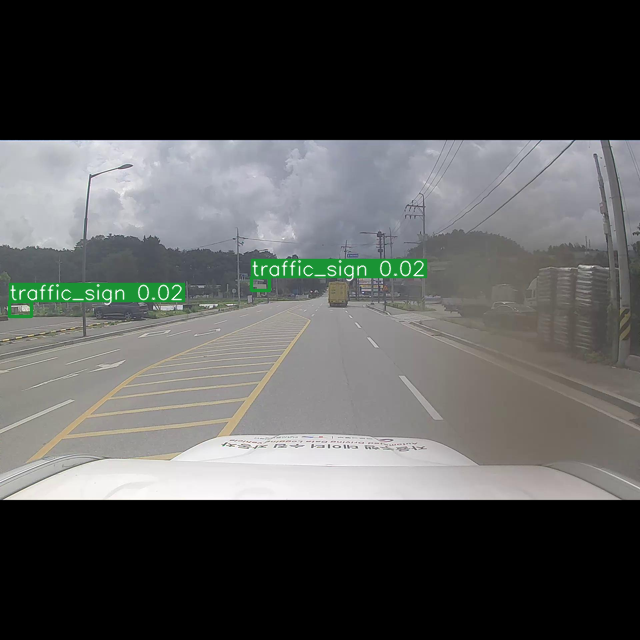

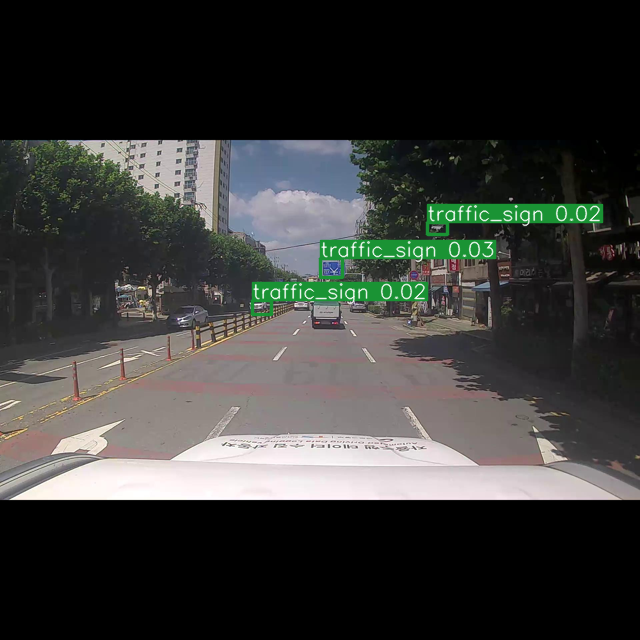

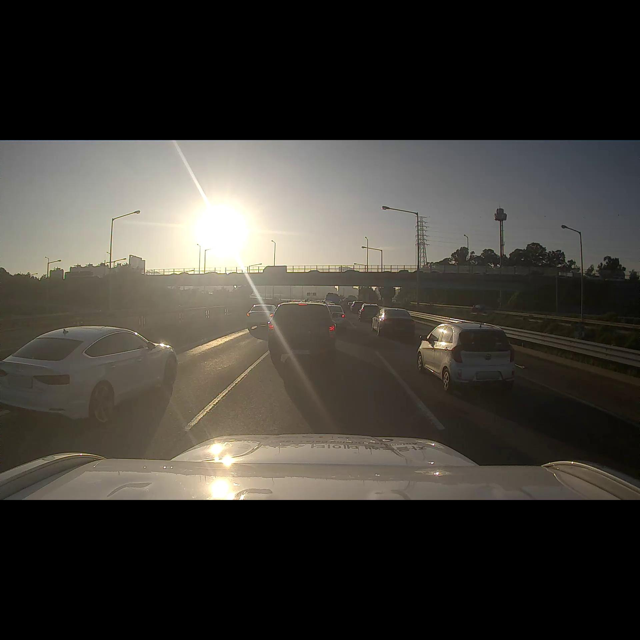

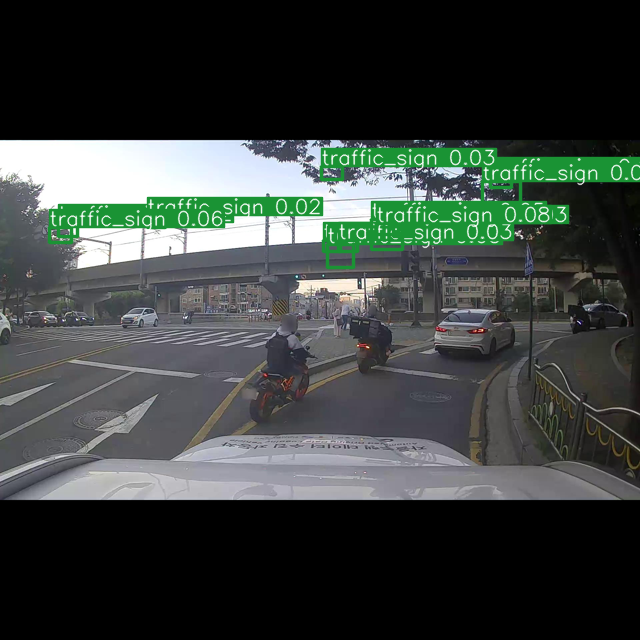

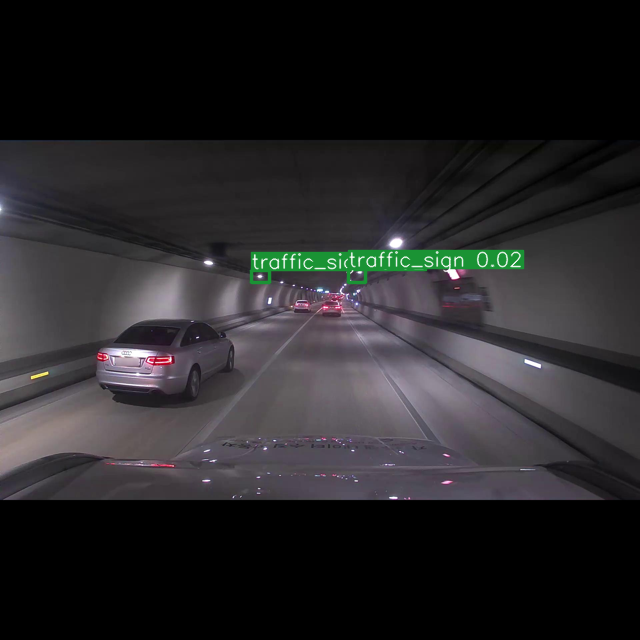

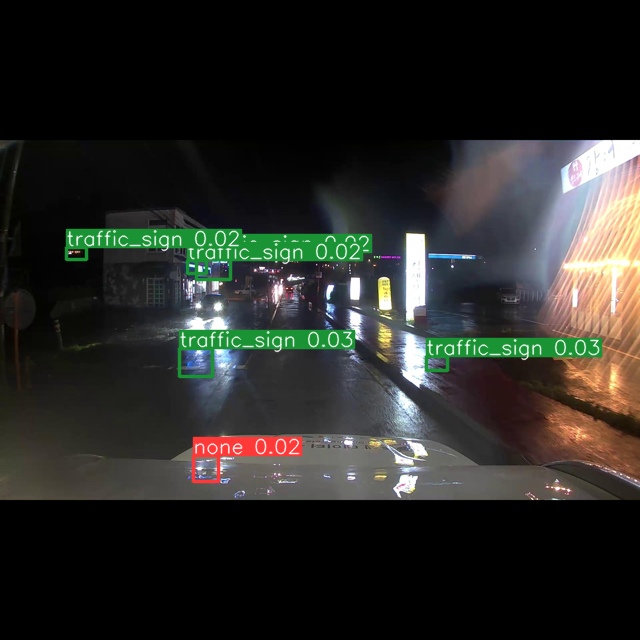

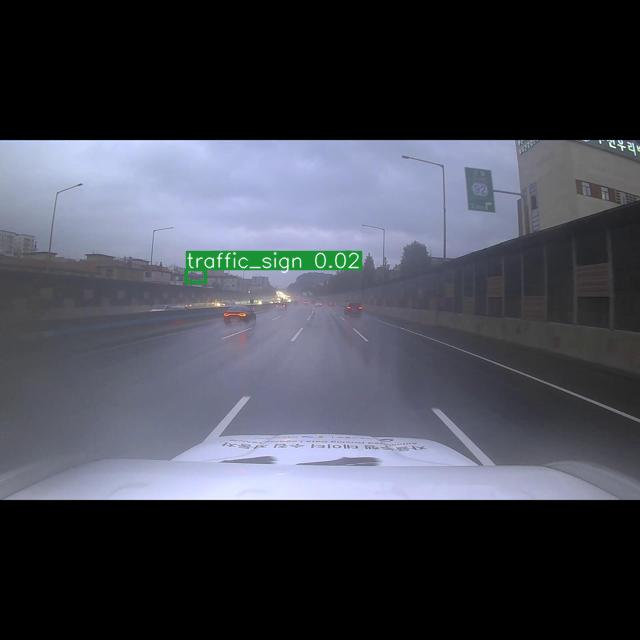

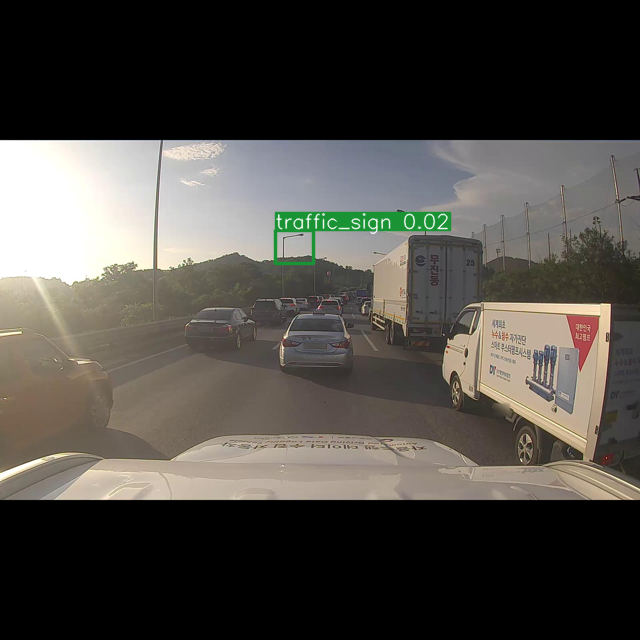

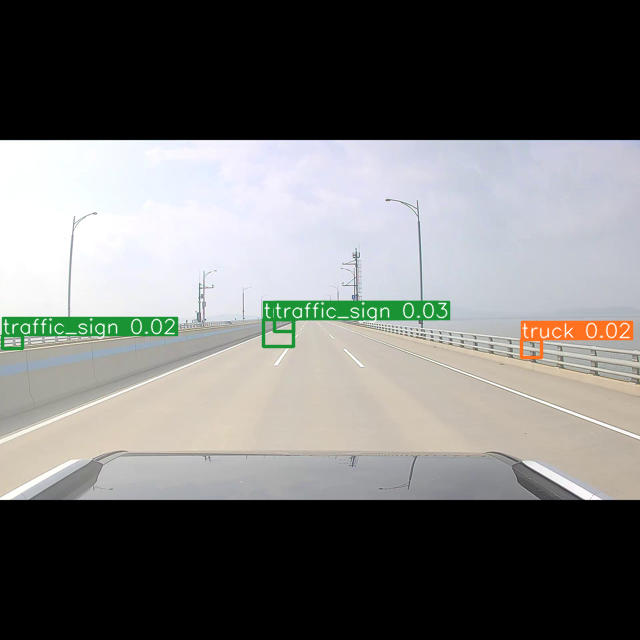

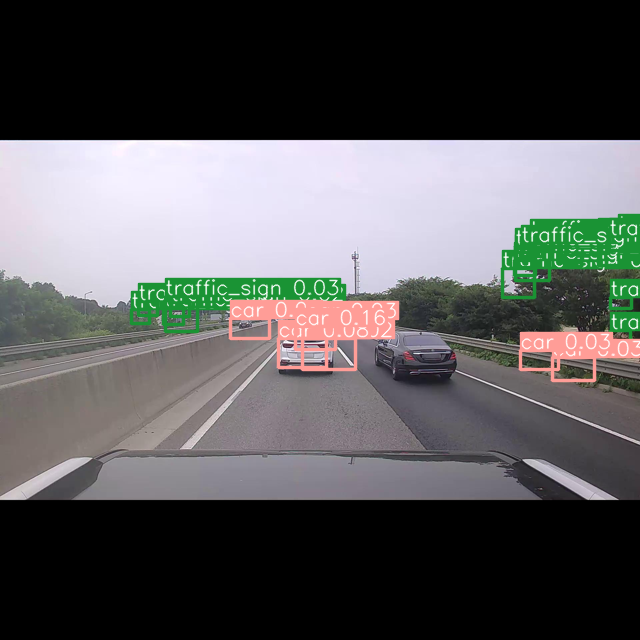

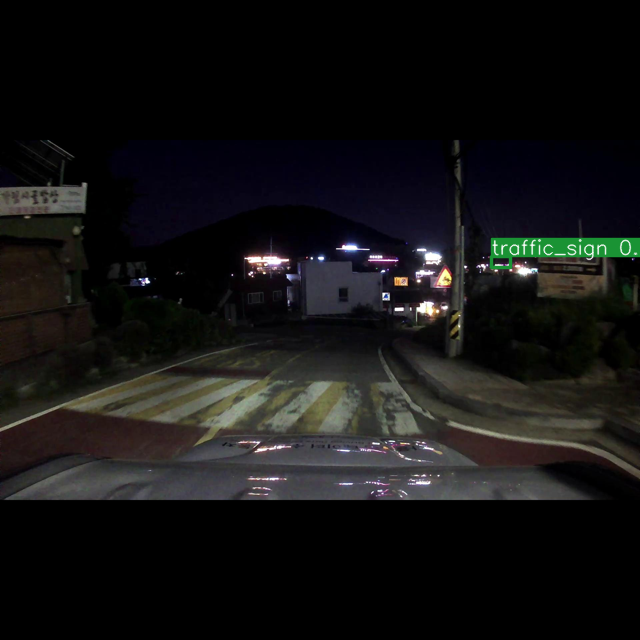

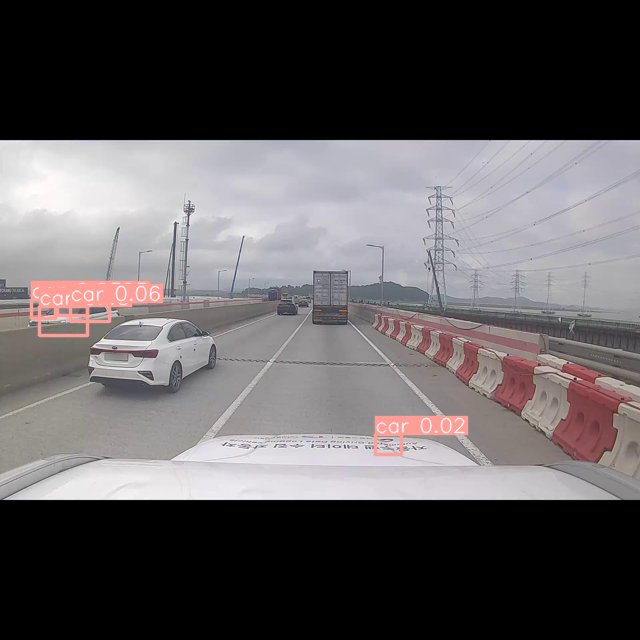

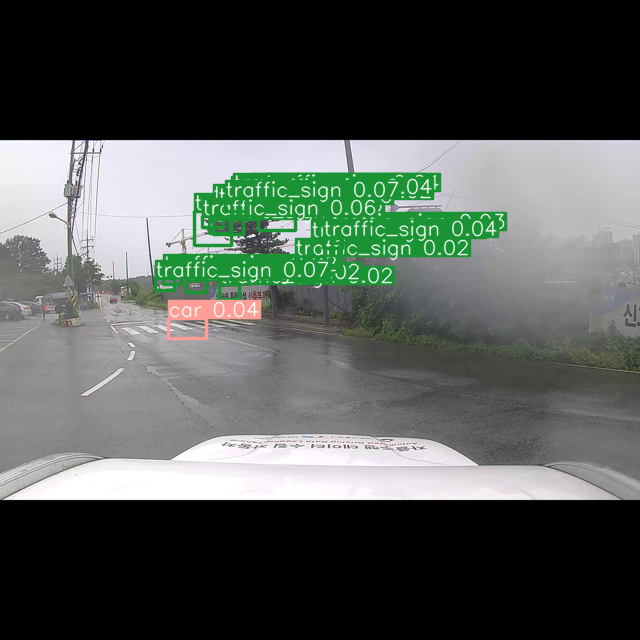

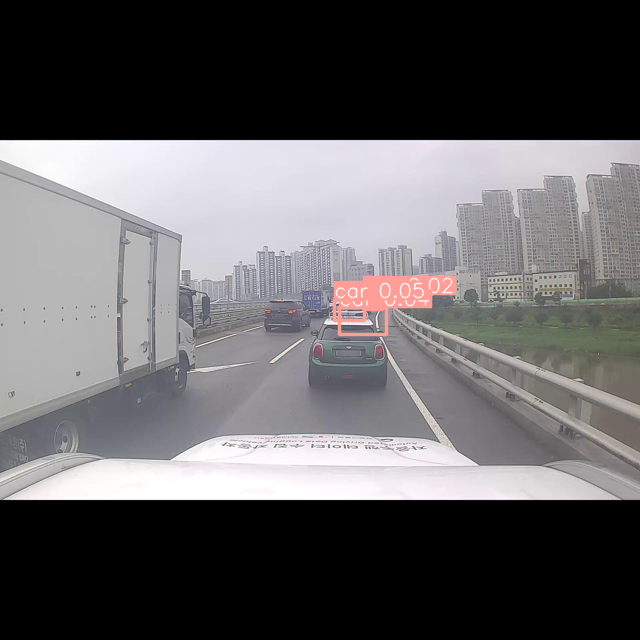

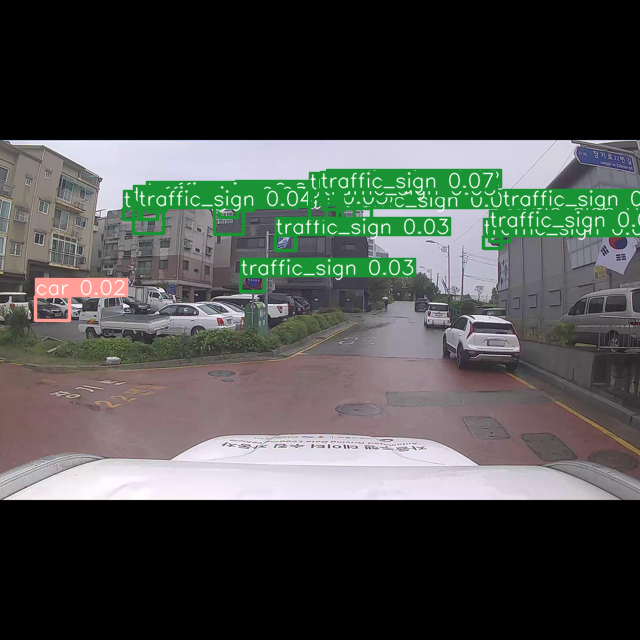

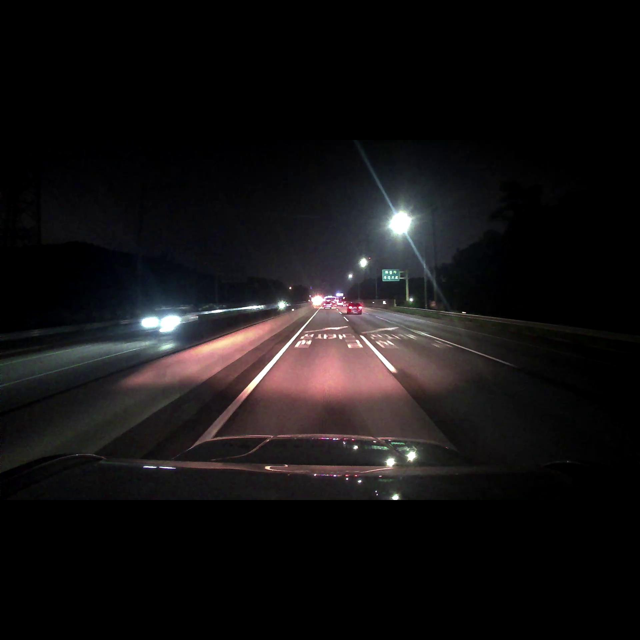

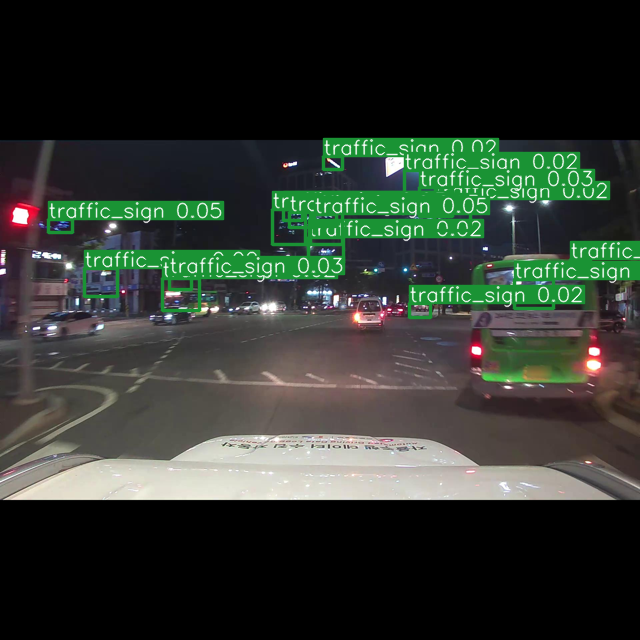

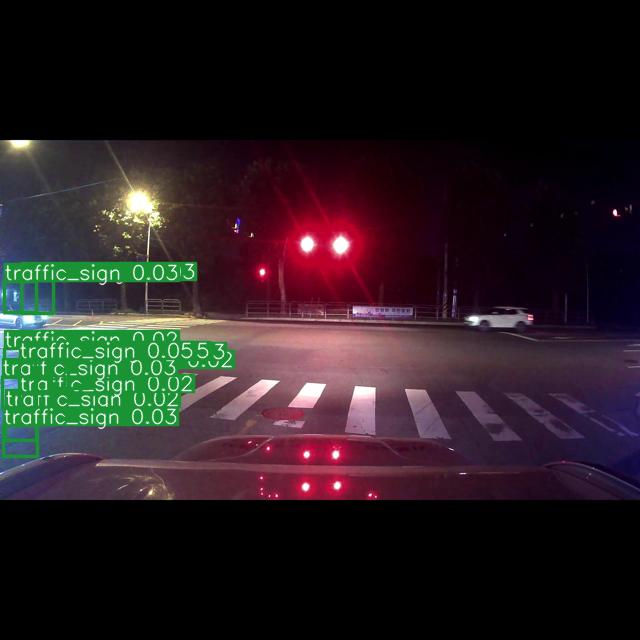

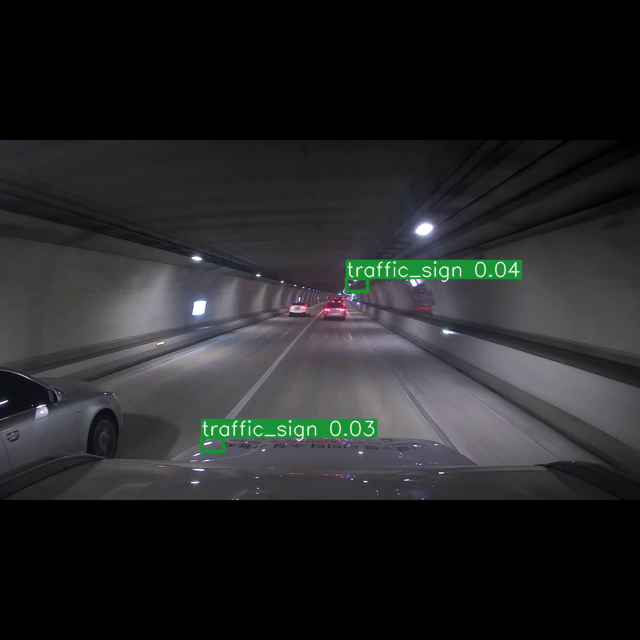

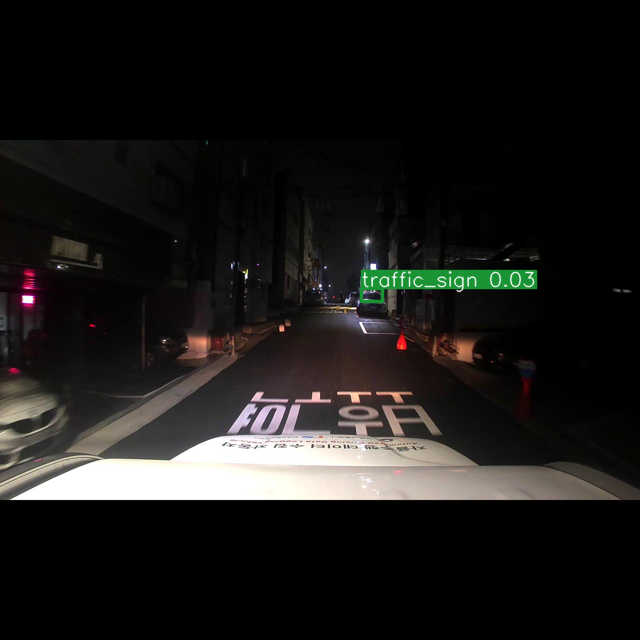

In [15]:
from PIL import Image
import os
from models.common import Detections
from utils.general import non_max_suppression
from IPython.display import display
from pathlib import Path

class TimeStamp:
    def __init__(self, t):
        self.t = t
times = (TimeStamp(0), TimeStamp(0), TimeStamp(0))
model = model.to('cpu')

transform = transforms.Compose([
            transforms.Pad((0, 420, 0, 420)),
            transforms.Resize((640, 640)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
          ])
# 1. Get predictions for all images
base_path = '/content/drive/MyDrive/data/2DB/test/images/'
img_names = os.listdir(base_path)[:20]

# 1. Get predictions for all images
predictions = []
tensor_shapes = []
inverse_label_map = {v: k for k, v in train_dataset.label_map.items()}
print(inverse_label_map)


for img_name in img_names:
    image_path = Path(base_path) / img_name
    image = Image.open(image_path)
    tensor = transform(image).unsqueeze(0)
    tensor_shapes.append(tensor.shape)  # Store the tensor shape

    result = model(tensor)
    nms_result = non_max_suppression(result[0], conf_thres=0.02, iou_thres=0.3)
    predictions.append(nms_result)

# 2. Visualize the predictions using Detections class
for img_name, prediction, shape in zip(img_names, predictions, tensor_shapes):
    image_path = Path(base_path) / img_name
    image = Image.open(image_path).convert("RGB")
    width, height = image.size
    left_pad = (1920 - width) // 2
    right_pad = 1920 - width - left_pad
    top_pad = (1920 - height) // 2
    bottom_pad = 1920 - height - top_pad

    # Step 3: Apply the padding
    image_padded = ImageOps.expand(image, (left_pad, top_pad, right_pad, bottom_pad), fill='black')

    # Step 4: Resize the padded image to 640x640
    image_resized = image_padded.resize((640, 640))
    # Convert PIL Image to numpy for Detections class
    image_np = np.array(image_resized)

    # Create Detections object and display
    detections = Detections(ims=[image_np], pred=prediction, files=[img_name], names=inverse_label_map, times=times, shape=shape)
    detections.show()



In [21]:
from yolov5.val import run

names = {v: k for k, v in label_map.items()}
val = '/content/drive/Mydrive/2DB/test/images'
nc = len(val)

data_dict = {
    "names": names,
    "val": val,
    "nc": nc
}
# test
model.eval()
compute_loss = ComputeLoss(model)
results, _, _ = run(data_dict, batch_size=8, device='cpu', model=model, dataloader=test_loader, compute_loss=compute_loss)
print_results("Test", results)

                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 13/13 [01:07<00:00,  5.22s/it]
                   all        100       1626   3.33e-06   0.000602   1.68e-06   5.03e-07



Test Results
--------------------------------------------------
Precision: 0.0000
Recall: 0.0006
mAP@0.5: 0.0000
mAP@0.5:0.95: 0.0000
Box Loss: 0.1052
Obj Loss: 0.0480
Class Loss: 0.4503
--------------------------------------------------
